In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from os import listdir
from os.path import isfile, join

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (4,3)  # good default size for column-width figure

# Water
### Finding T2 in water by varying tau

In [3]:
# NOTE before you import from excel, go in and delete column F from the sheet
folder = 'data/feb28/'
filenames = ['15491_water_tau01.csv', '15541_water_tau02.csv', '16011_water_tau03.csv', '16071_water_tau05.csv', '16131_water_tau07.csv', '16181_water_tau09.csv', '16231_water_tau11.csv', '16271_water_tau13.csv', '16321_water_tau15.csv', '16391_water_tau17.csv', '16431_water_tau19.csv', '16471_water_tau21.csv']
files = [folder + name for name in filenames]
tau_arr1 = np.array([1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]) * 1E-3  # Tau [s]

sets1 = []  # creates list of datasets

for path in files:
    df = pd.read_csv(path, header=None)
    df.columns = ['Header', 'Headerdata', 'n1', 't', 'V']
    df = df.drop(columns=['n1'])
    sets1.append(df)

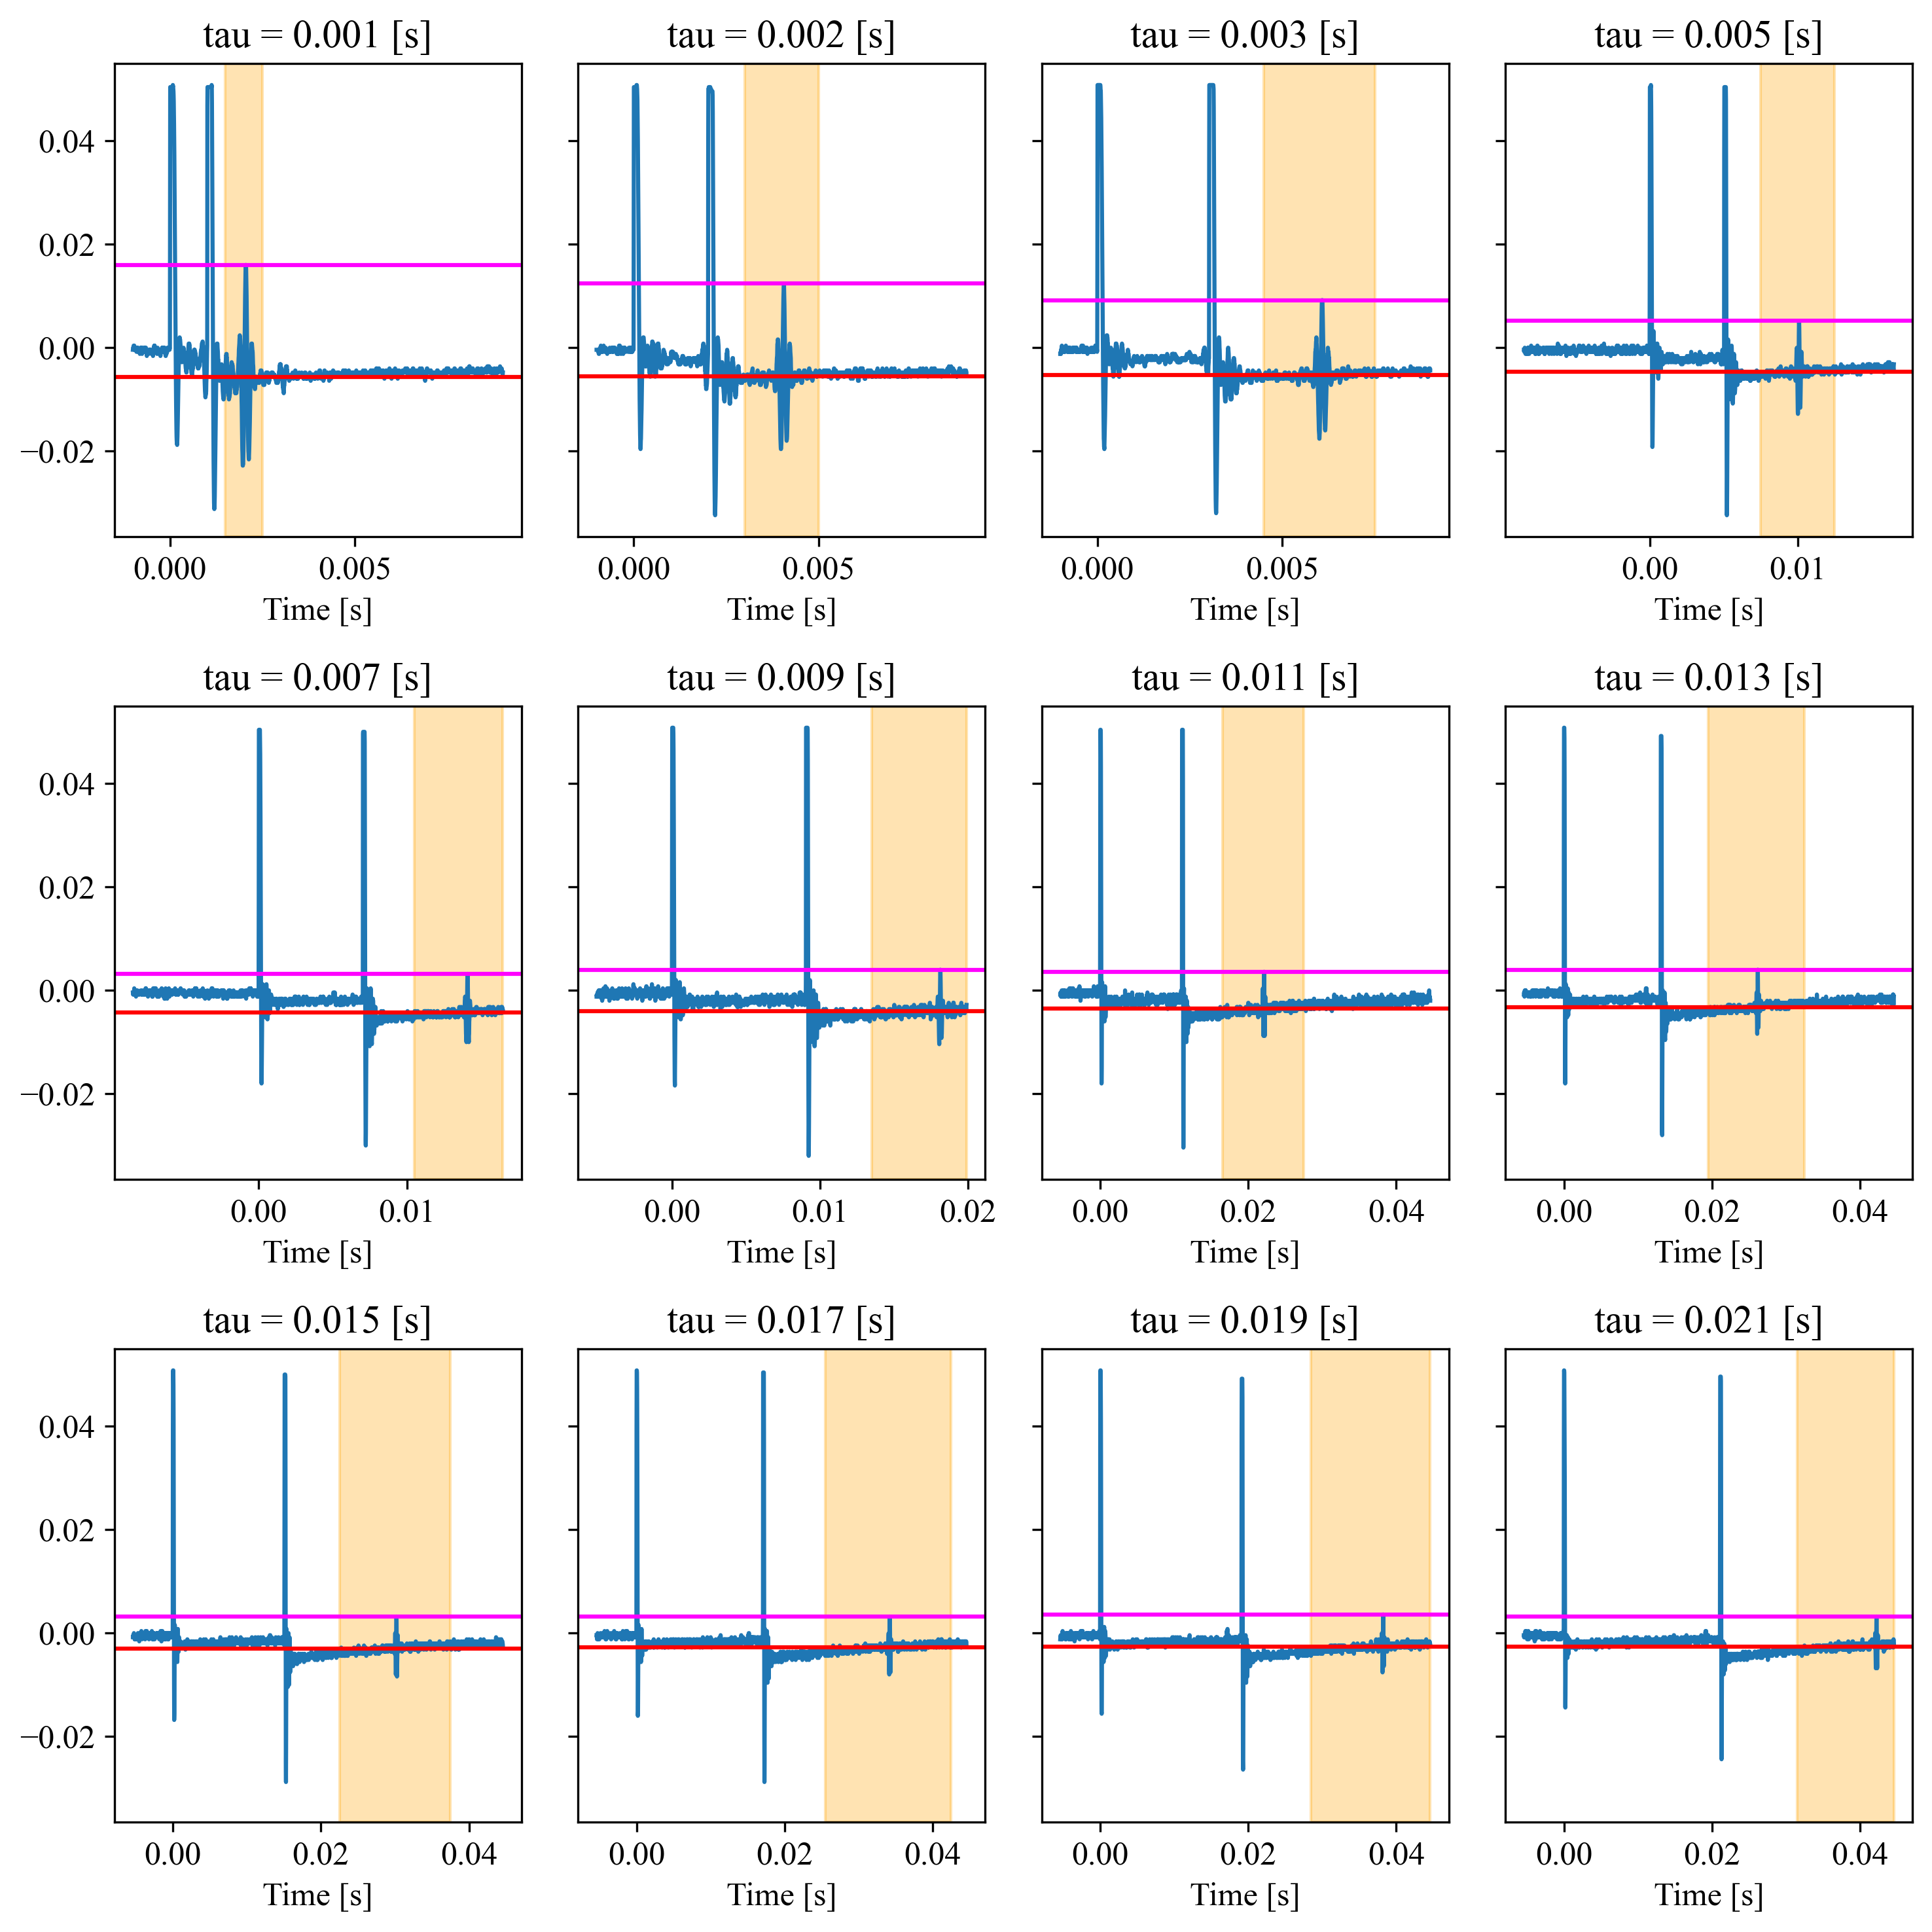

In [4]:
fig1, ax1 = plt.subplots(3, 4, figsize=(10, 10), tight_layout=True, sharey=True)
maxvals1 = []

for i, ax in enumerate(ax1.flat):
    data = sets1[i]
    times = data['t'].to_numpy()
    volts = data['V'].to_numpy()
    taui = tau_arr1[i]
    
    lower_val = 2 * taui - 0.5 * taui
    upper_val = 2 * taui + 0.5 * taui
    
    lower_idx = (np.abs(times - lower_val)).argmin()
    upper_idx = (np.abs(times - upper_val)).argmin()

    y = volts[lower_idx:upper_idx]
    amax = np.amax(y)
    avg = np.mean(y)
    maxvals1.append(amax - avg)
    
    ax.plot(times, volts)
    ax.axvspan(times[lower_idx], times[upper_idx], color="orange", alpha=0.3)
    ax.axhline(avg, color="red")
    ax.axhline(amax, color="magenta")
    ax.set_xlabel("Time [s]")
    ax.set_title(f"tau = {taui:.3f} [s]")

Text(0.01, 0.015, 'T2 = 0.003 +/- 0.007')

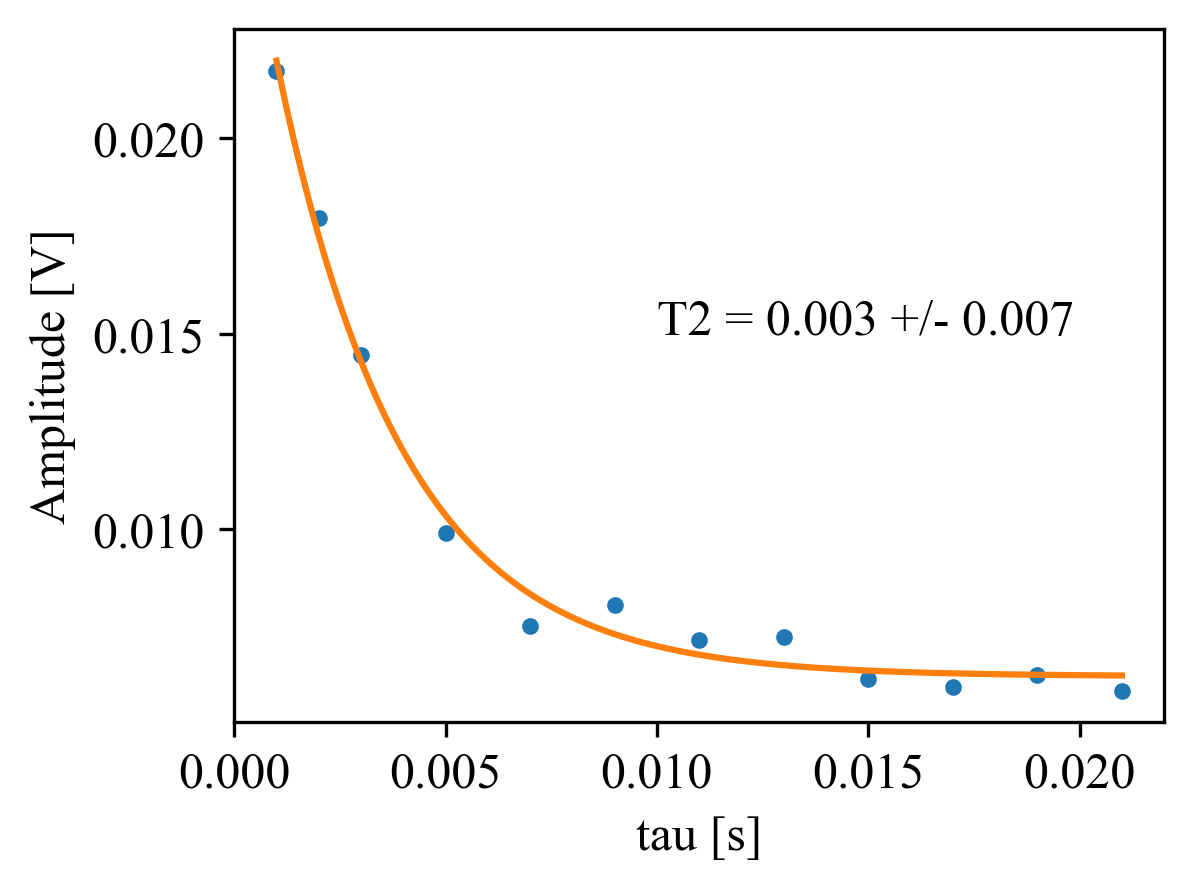

In [5]:
x = tau_arr1
y = maxvals1
dy = np.ones(len(maxvals1)) * 0.00005

# Have an initial guess as to what the values of the parameters are
a_guess = 0.04
b_guess = 0.001
c_guess = 0.05

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(-b * t) + c,
    x, y, p0=(a_guess, b_guess, c_guess), sigma=dy
)

# The optimised values of the parameters are
a = popt[0]
b = popt[1]
c = popt[2]

db = pcov[1][1]

T2_water = 1 / b
dT2_water = db / b**2

x2 = np.linspace(x[0], x[-1], 1000)
plt.plot(x, y, '.')
plt.plot(x2, a * np.exp(-b * x2) + c)
plt.xlabel('tau [s]')
plt.ylabel('Amplitude [V]')
plt.text(0.01, 0.015, f"T2 = {T2_water:.3f} +/- {dT2_water:.3f}")

Using the relationship $M = A \exp(-\tau/T_2)$, use parameter b from the fit to get T2.

### Finding T1 in water by varying T

In [6]:
folder = 'data/march2/'
filenames = [f for f in listdir(folder) if isfile(join(folder, f))]
files = [folder + name for name in filenames]

period_arr2 = np.array([1000, 800, 900, 700, 600, 500, 400, 300, 200, 100, 50, 25, 10, 5, 75]) * 1E-3  # T [s]
tau2 = 3E-3 # [s]

lower_val = 2 * tau2 - 0.5 * tau2
upper_val = 2 * tau2 + 0.5 * tau2

sets2 = []  # creates list of datasets

for path in files:
    df = pd.read_csv(path, header=None)
    df.columns = ['Header', 'Headerdata', 'n1', 't', 'V', 'n2']
    df = df.drop(columns=['n1', 'n2'])
    sets2.append(df)

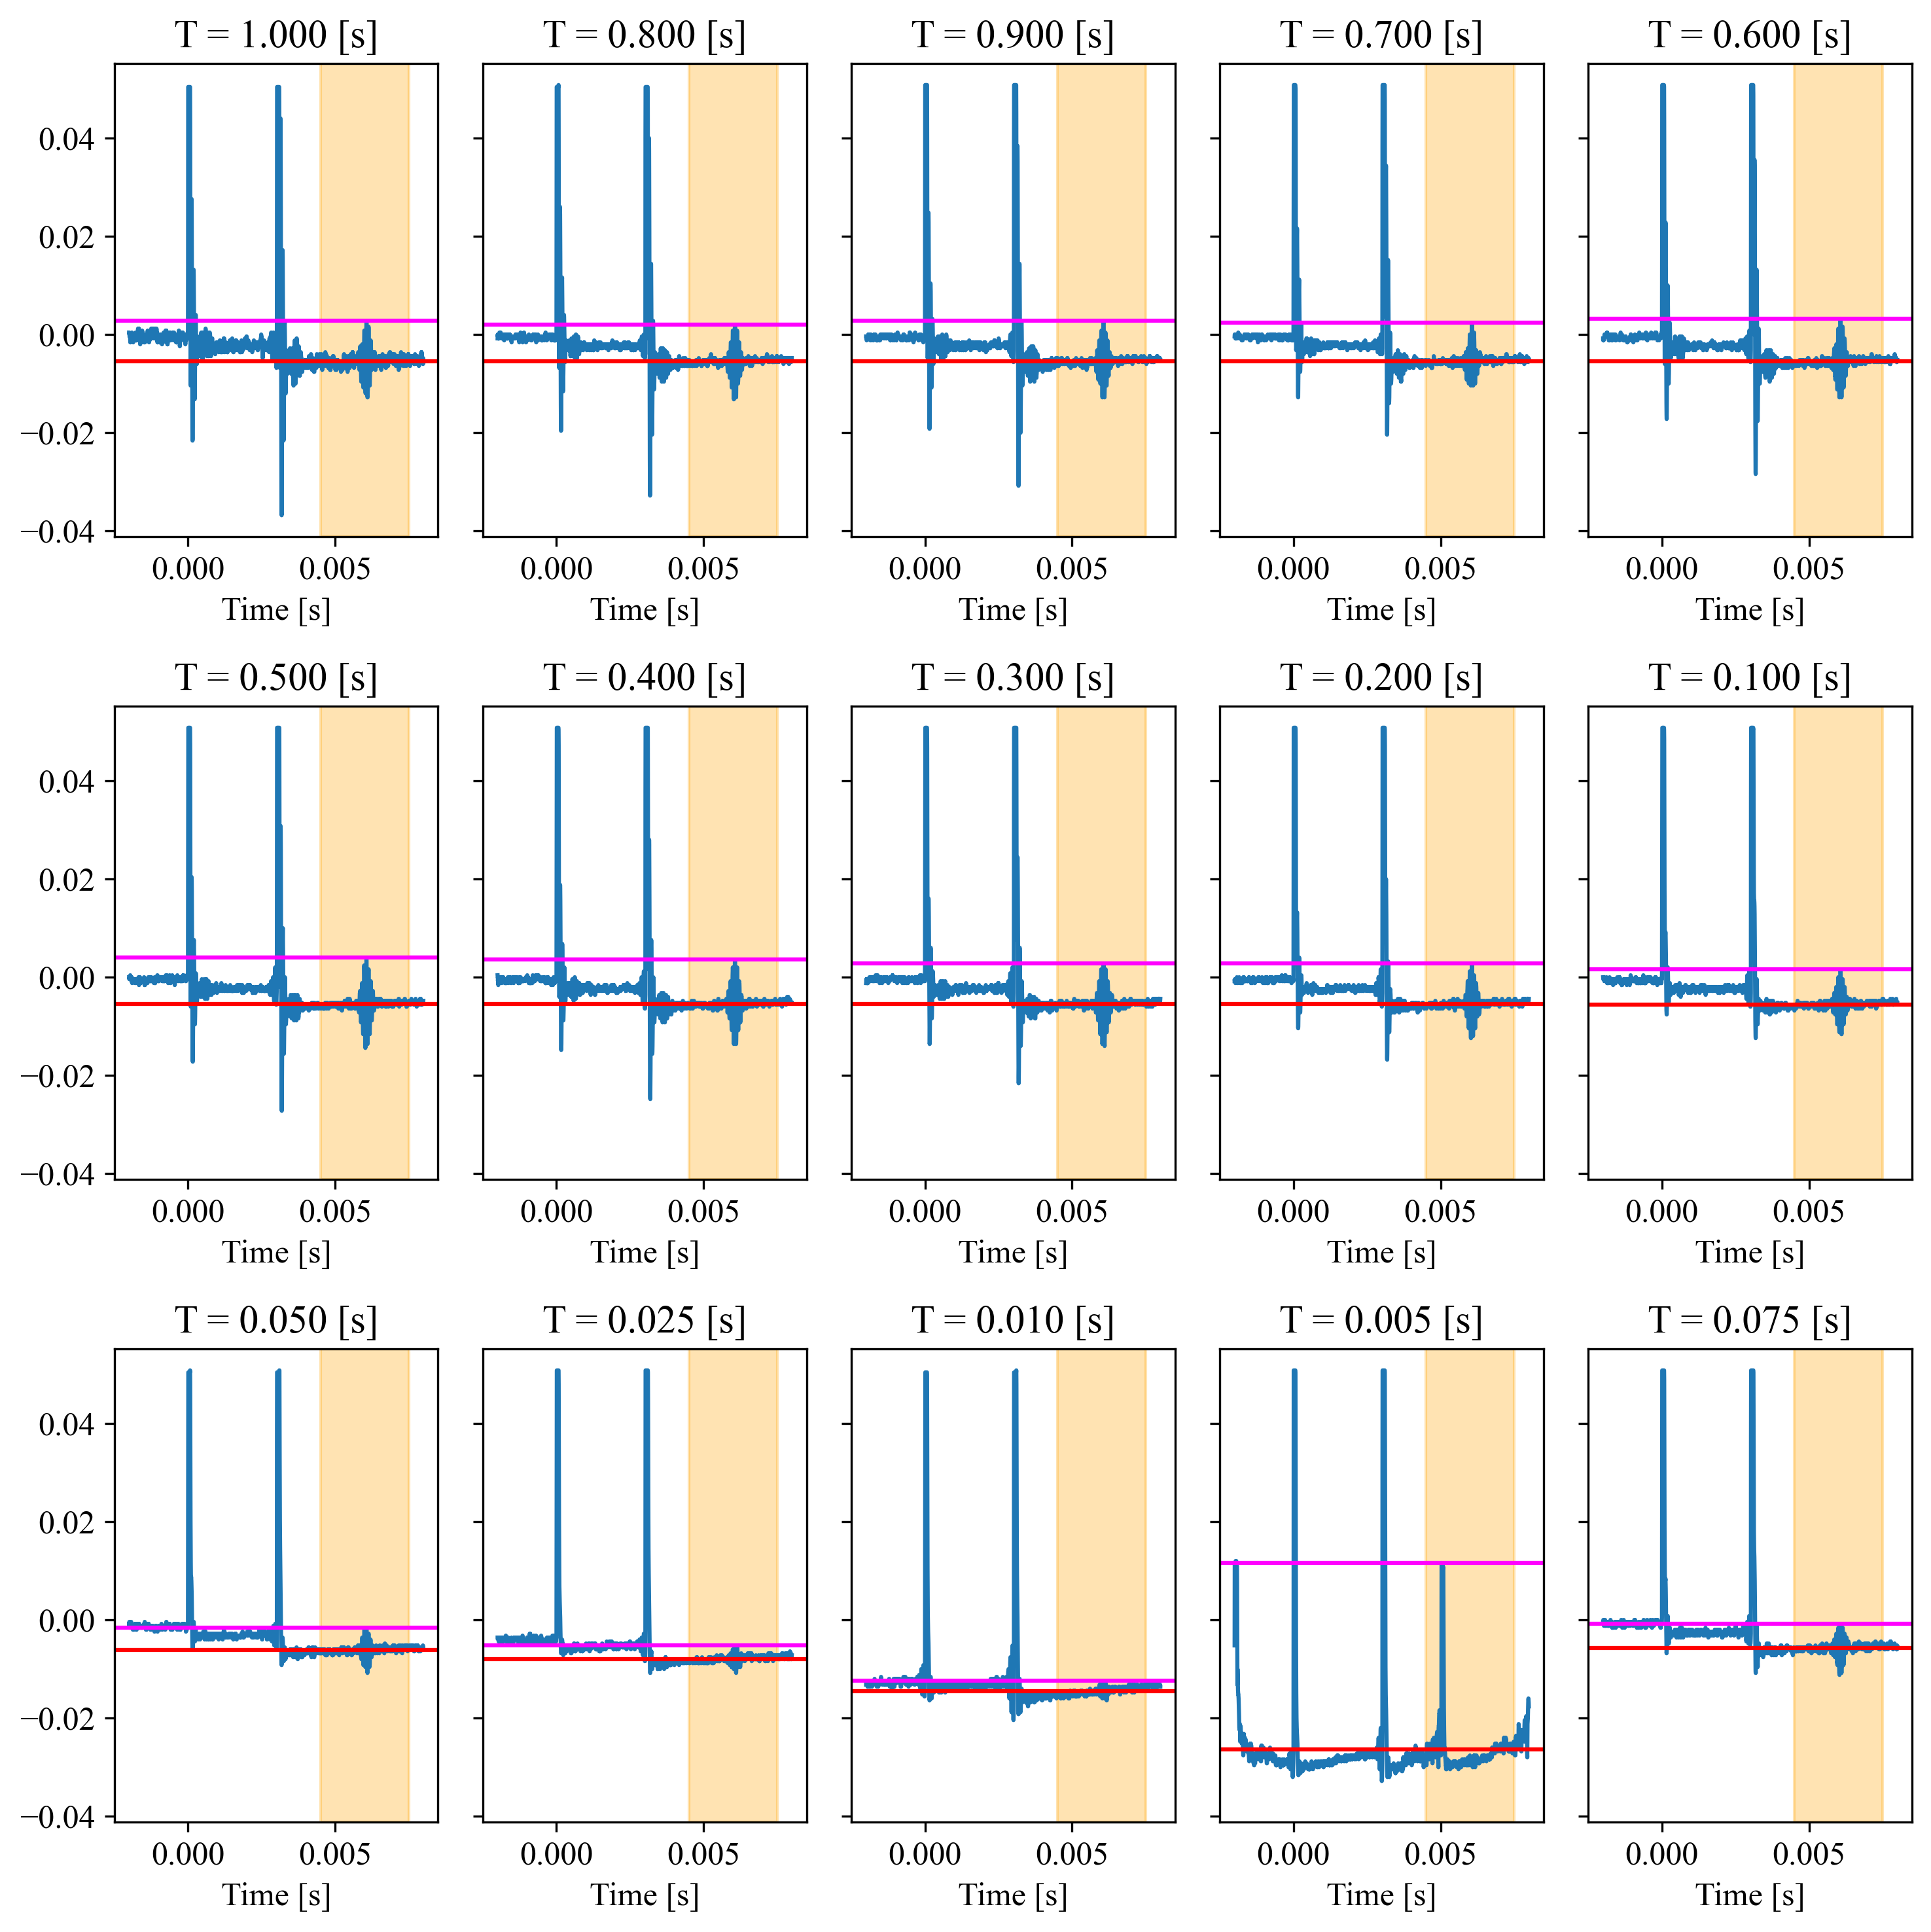

In [7]:
fig2, ax2 = plt.subplots(3, 5, figsize=(10, 10), tight_layout=True, sharey=True)
maxvals2 = []

for i, ax in enumerate(ax2.flat):
    data = sets2[i]
    times = data['t'].to_numpy()
    volts = data['V'].to_numpy()
    period_i = period_arr2[i]
    
    lower_idx = (np.abs(times - lower_val)).argmin()
    upper_idx = (np.abs(times - upper_val)).argmin()

    y = volts[lower_idx:upper_idx]
    amax = np.amax(y)
    avg = np.mean(y)
    maxvals2.append(amax - avg)
    
    ax.plot(times, volts)
    ax.axvspan(times[lower_idx], times[upper_idx], color="orange", alpha=0.3)
    ax.axhline(avg, color="red")
    ax.axhline(amax, color="magenta")
    ax.set_xlabel("Time [s]")
    ax.set_title(f"T = {period_i:.3f} [s]")

Text(0, 0.5, 'Amplitude [V]')

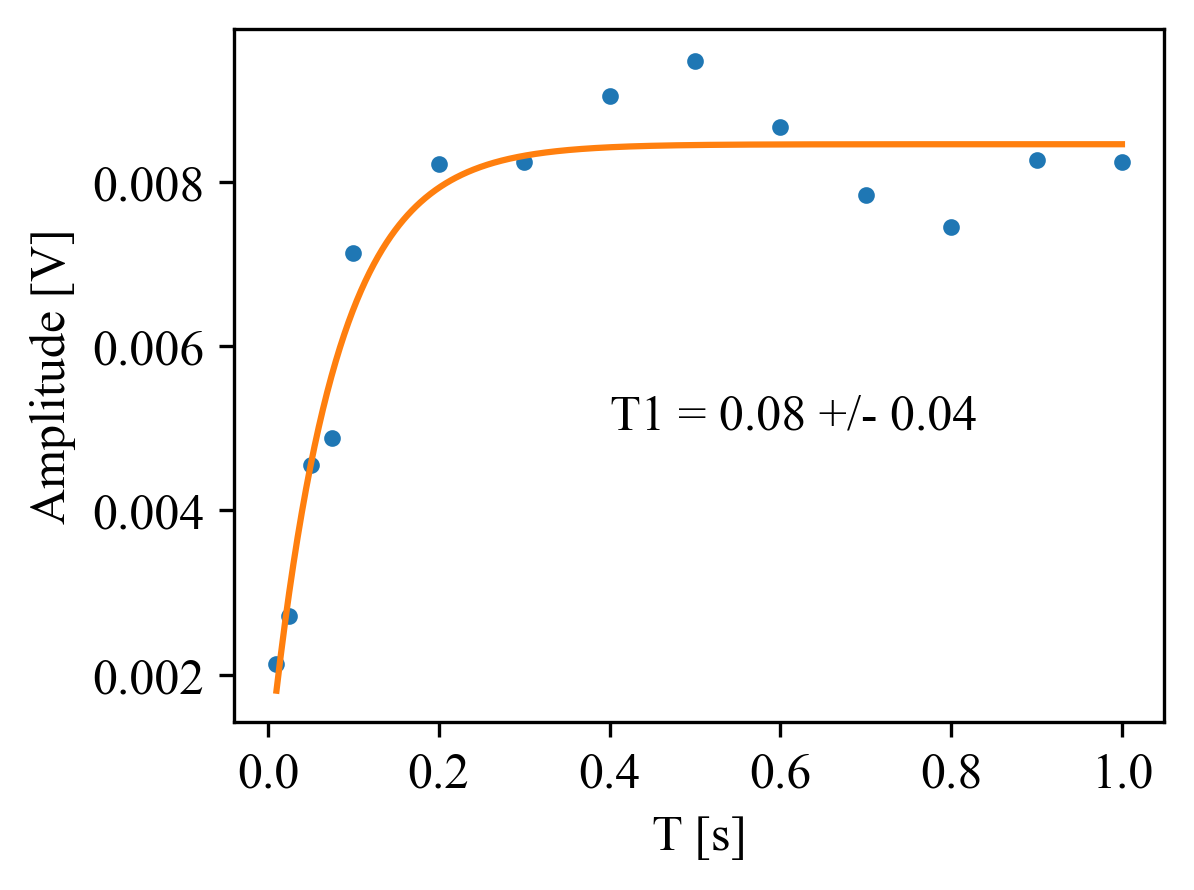

In [8]:
x = np.delete(period_arr2, -2)
y = np.delete(maxvals2, -2)
plt.plot(x, y, '.')
dy = np.ones(len(x)) * 0.00005  # Uncertainty on voltage measurement

# Have an initial guess as to what the values of the parameters are
a_guess = 0.1
b_guess = 100
c_guess = 0.995

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(
    lambda t, a, b, c: 1 - (a * np.exp(-b * t) + c),
    x, y, p0=(a_guess, b_guess, c_guess), sigma=dy
)

# The optimised values of the parameters are
a = popt[0]
b = popt[1]
c = popt[2]

db = pcov[1][1]

T1_water = 1 / b
dT1_water = db / b ** 2

x2 = np.linspace(np.amin(x), np.amax(x), 1000)
plt.plot(x2, 1 - (a * np.exp(-b * x2) + c))
plt.text(0.4, 0.005, f"T1 = {T1_water:.2f} +/- {dT1_water:.2f}")
plt.xlabel('T [s]')
plt.ylabel('Amplitude [V]')

In [9]:
T1 = 1 / b
dT1 = db / b ** 2
print(f"T1 = {T1:.2f} +/- {dT1:.2f}")

T1 = 0.08 +/- 0.04


# Iron
### Finding T2

In [21]:
folder = 'data/march9_T2/'
filenames = [f for f in listdir(folder) if isfile(join(folder, f))]
files = [folder + name for name in filenames]

tau_arr3 = np.array([1, 3, 5, 4.5, 4, 3.5, 2.5, 2, 1.5, 0.5]) * 1E-3  # tau [s]

sets3 = []  # creates list of datasets

for path in files:
    df = pd.read_csv(path, header=None)
    df.columns = ['Header', 'Headerdata', 'n1', 't', 'V', 'n2']
    df = df.drop(columns=['n1', 'n2'])
    sets3.append(df)

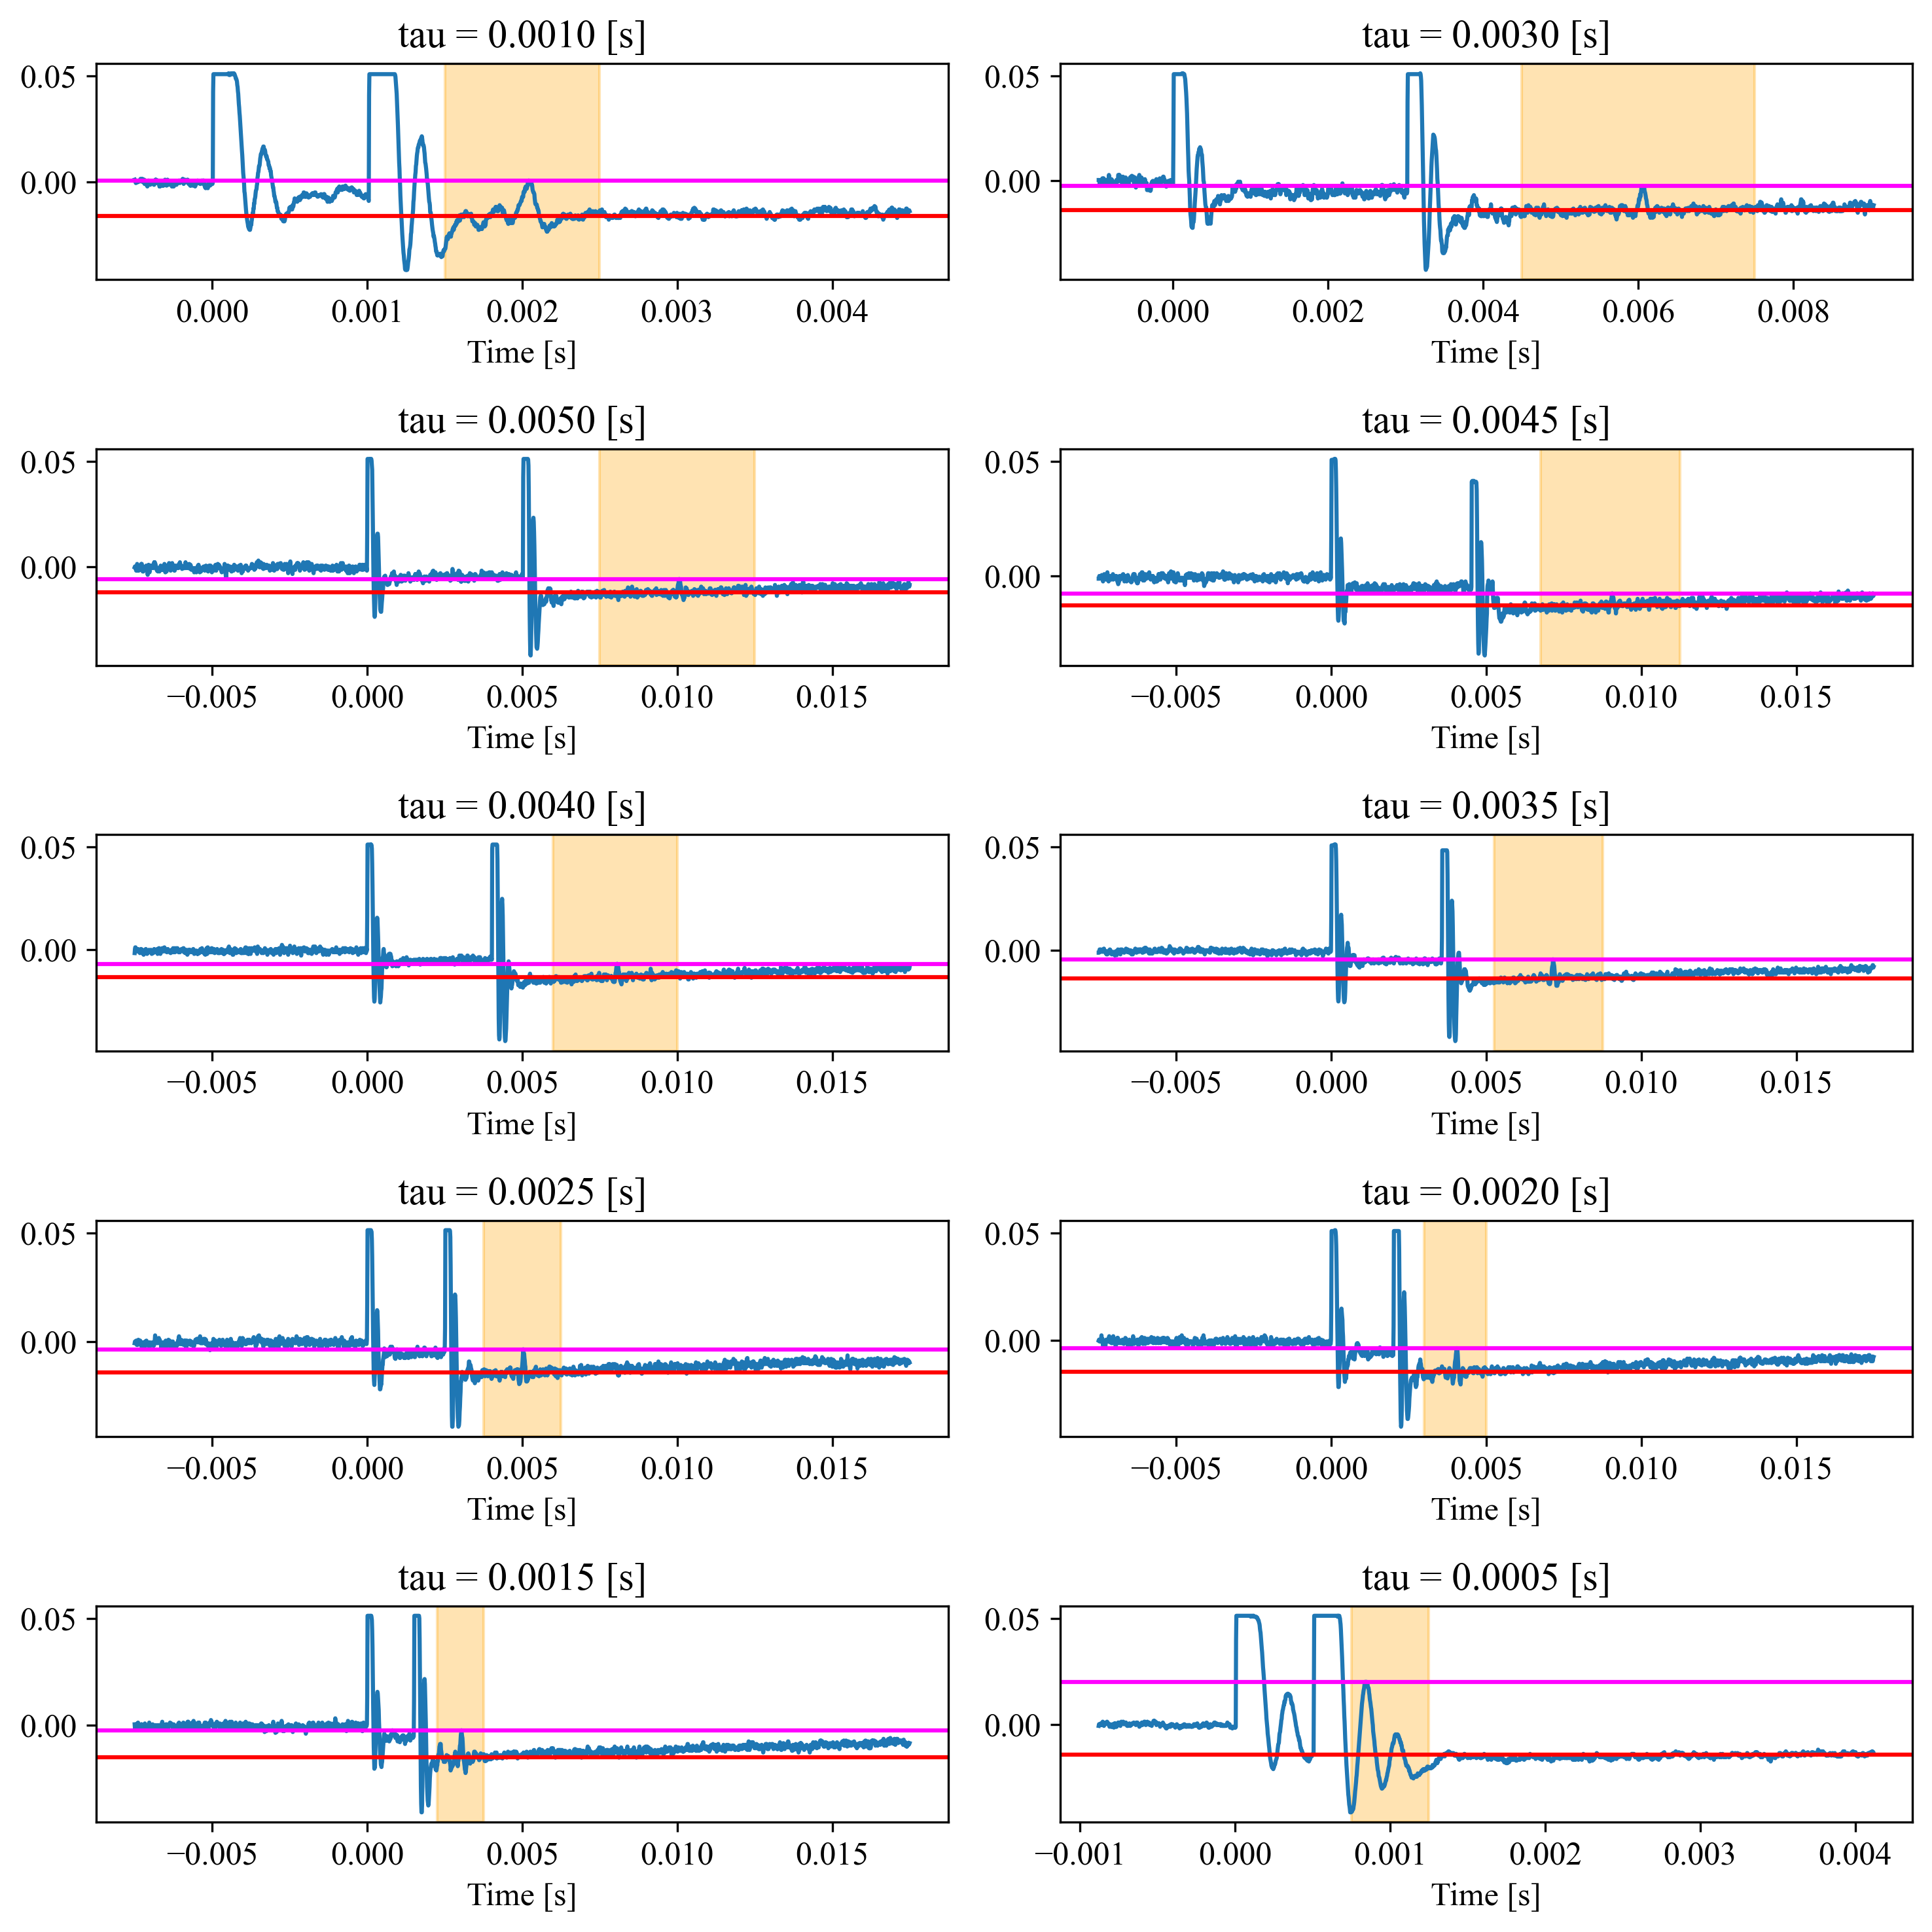

In [22]:
fig3, ax3 = plt.subplots(5, 2, figsize=(10, 10), tight_layout=True)
maxvals3 = []

for i, ax in enumerate(ax3.flat):
    data = sets3[i]
    times = data['t'].to_numpy()
    volts = data['V'].to_numpy()
    taui = tau_arr3[i]
    
    lower_val = 2 * taui - 0.5 * taui
    upper_val = 2 * taui + 0.5 * taui
    
    lower_idx = (np.abs(times - lower_val)).argmin()
    upper_idx = (np.abs(times - upper_val)).argmin()

    y = volts[lower_idx:upper_idx]
    amax = np.amax(y)
    avg = np.mean(y)
    maxvals3.append(amax - avg)
    
    ax.plot(times, volts)
    ax.axvspan(times[lower_idx], times[upper_idx], color="orange", alpha=0.3)
    ax.axhline(avg, color="red")
    ax.axhline(amax, color="magenta")
    ax.set_xlabel("Time [s]")
    ax.set_title(f"tau = {taui:.4f} [s]")
    ax.plot

In [24]:
x = np.delete(tau_arr3, -1)
y = np.delete(maxvals3, -1)
dy = np.ones(len(x)) * 0.00005

# Have an initial guess as to what the values of the parameters are
a_guess = 0.04
b_guess = 0.001
c_guess = 0.05

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(-b * t) + c,
    x, y, p0=(a_guess, b_guess, c_guess), sigma=dy
)

# The optimised values of the parameters are
a = popt[0]
b = popt[1]
c = popt[2]

db = pcov[1][1]

T2 = 1 / b
dT2 = db / b**2

print(f"T2 for water is {T2:.3f} +/- {dT2:.3f}")

x2 = np.linspace(x[0], x[-1], 1000)
plt.plot(x, y, '.')
# plt.plot(x2, a * np.exp(-b * x2) + c)
plt.xlabel('tau [s]')
plt.ylabel('Amplitude [V]')
plt.text(0.01, 0.015, f"T2 = {T2:.3f} +/- {dT2:.3f}")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

This looks weird and bad. We will be retaking this data.

### T1 for iron

In [13]:
folder = 'data/march9_T1/'
filenames = [f for f in listdir(folder) if isfile(join(folder, f))]
files = [folder + name for name in filenames]

period_arr4 = np.array([1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 75, 50, 25]) * 1E-3  # T [s]
tau4 = 1E-3 # [s]

lower_val = 2 * tau4 - 0.5 * tau4
upper_val = 2 * tau4 + 0.5 * tau4

sets4 = []  # creates list of datasets

for path in files:
    df = pd.read_csv(path, header=None)
    df.columns = ['Header', 'Headerdata', 'n1', 't', 'V', 'n2']
    df = df.drop(columns=['n1', 'n2'])
    sets4.append(df)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


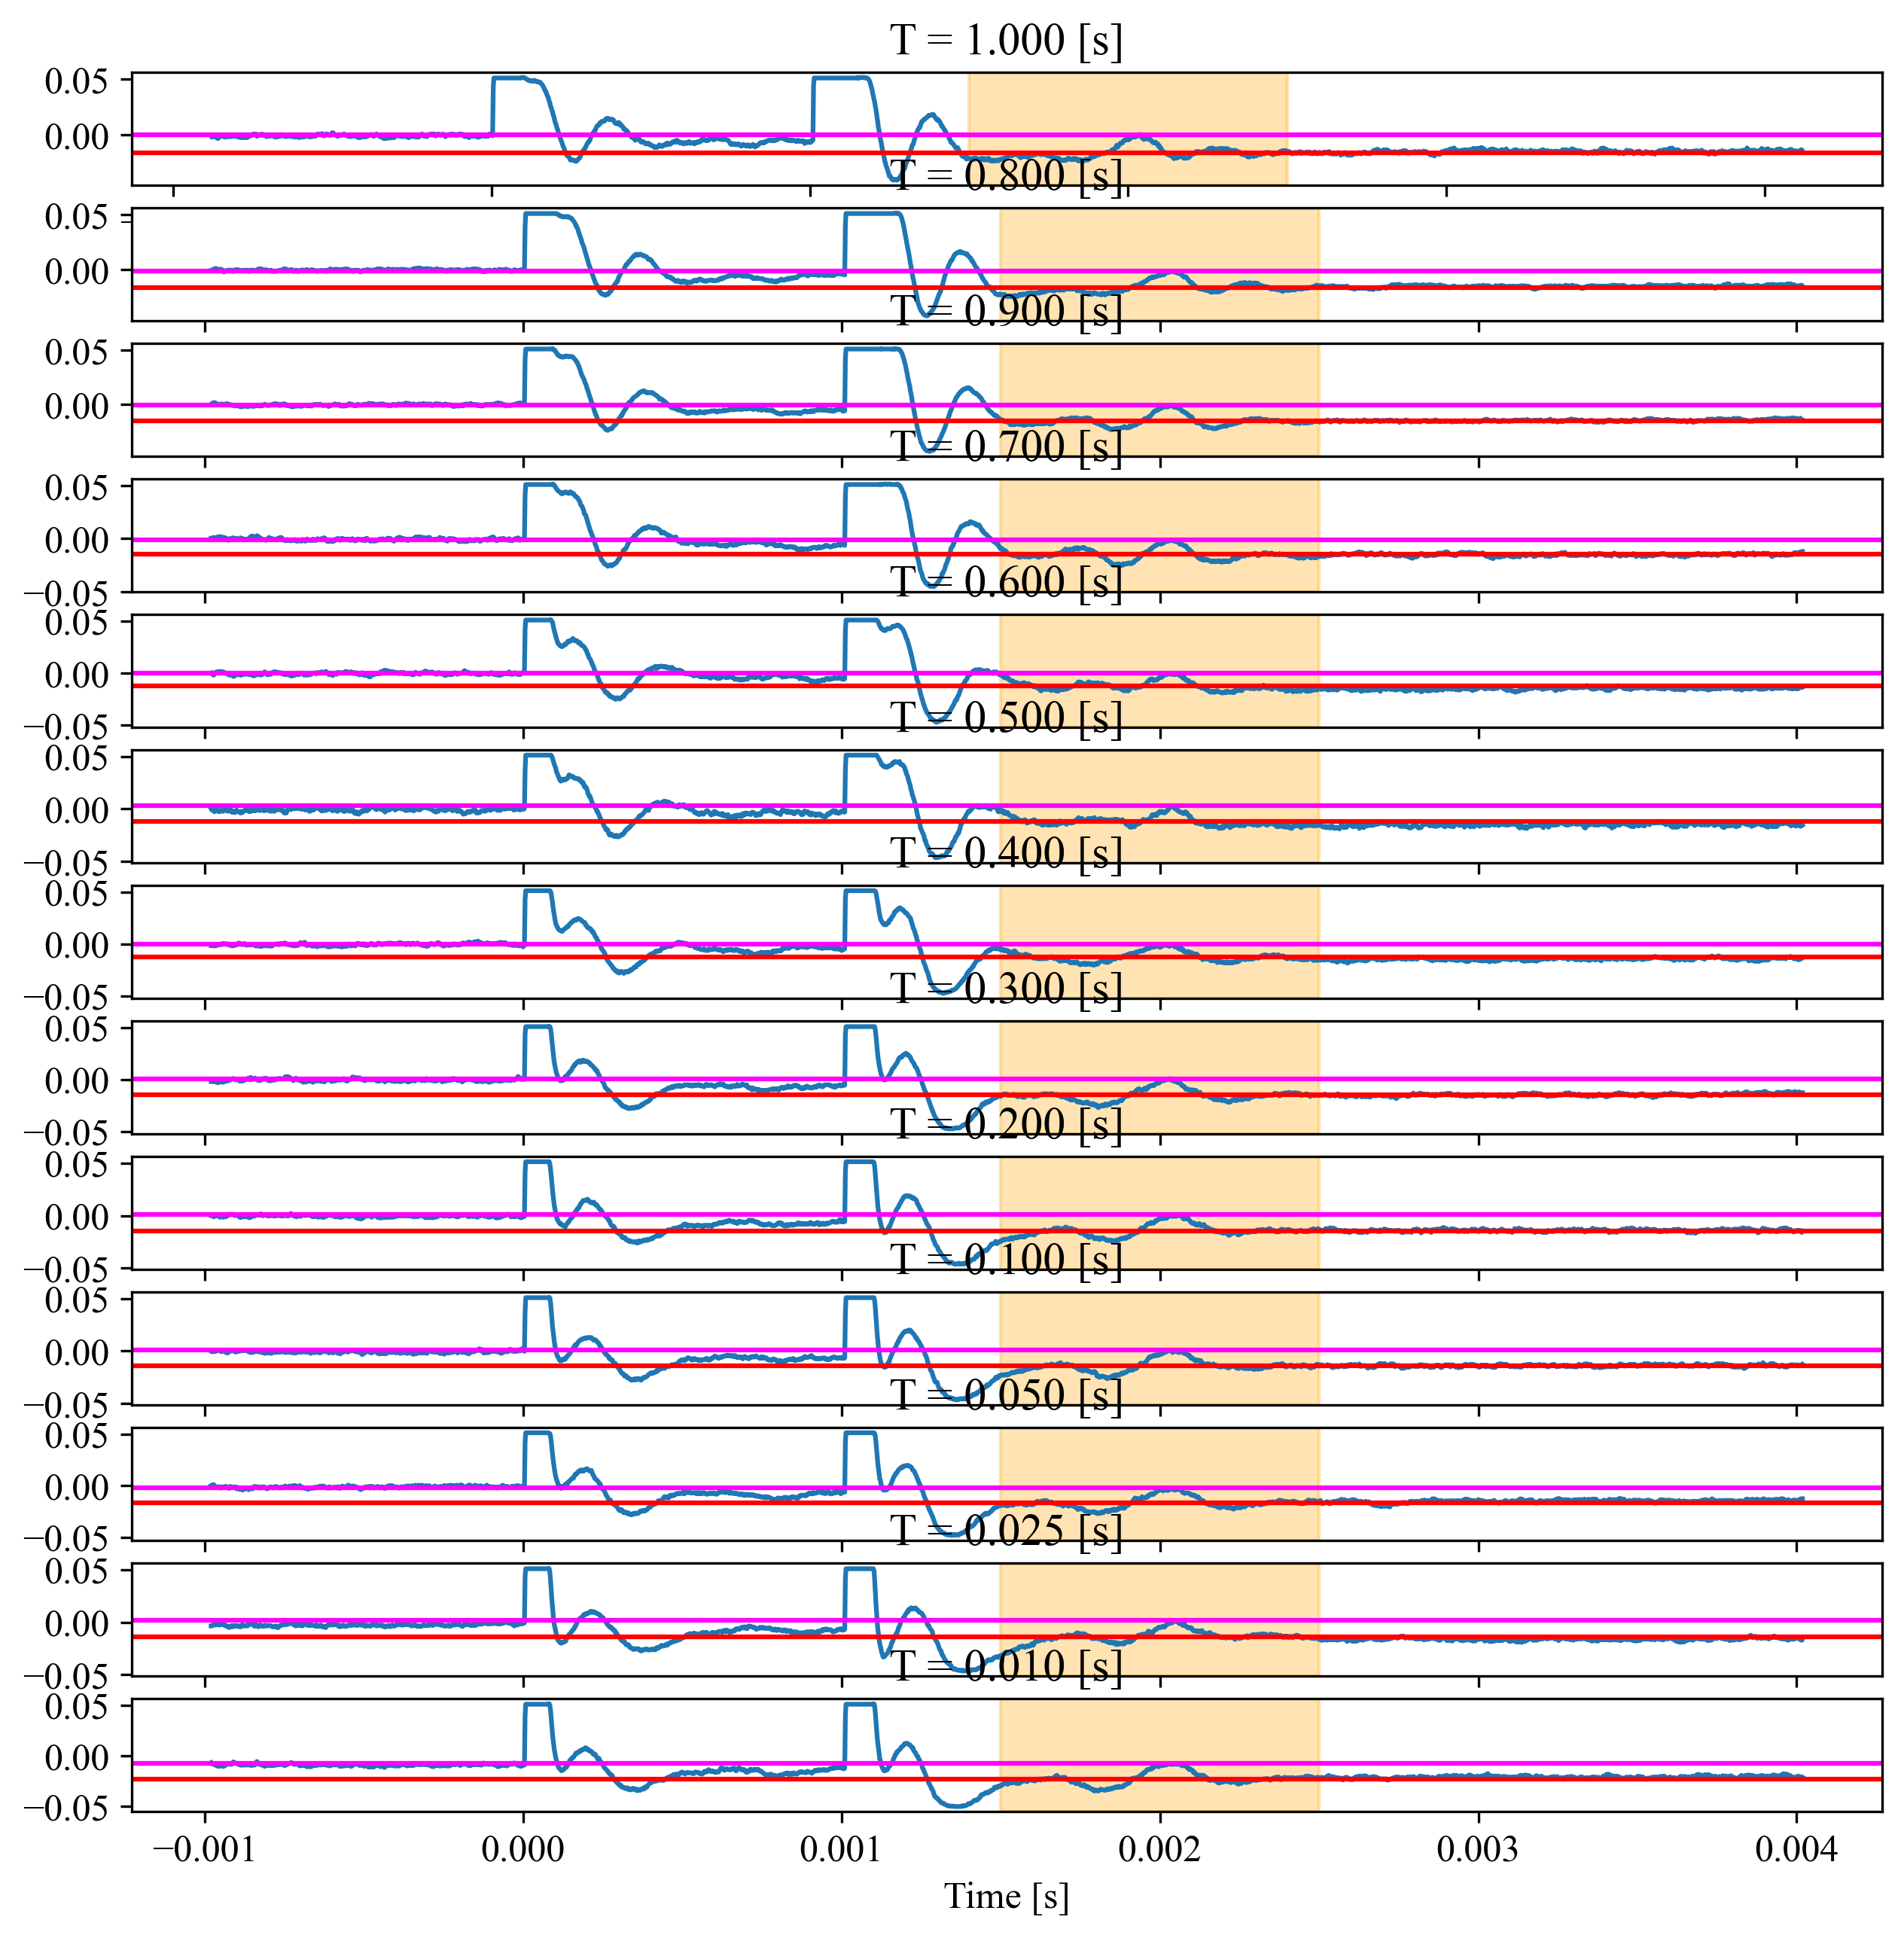

In [16]:
fig4, ax4 = plt.subplots(13, 1, figsize=(10, 10), tight_layout=True)
maxvals4 = []

for i, ax in enumerate(ax4.flat):
    data = sets4[i]
    times = data['t'].to_numpy()
    volts = data['V'].to_numpy()
    period_i = period_arr2[i]
    
    lower_idx = (np.abs(times - lower_val)).argmin()
    upper_idx = (np.abs(times - upper_val)).argmin()

    y = volts[lower_idx:upper_idx]
    amax = np.amax(y)
    avg = np.mean(y)
    maxvals4.append(amax - avg)
    
    ax.plot(times, volts)
    ax.axvspan(times[lower_idx], times[upper_idx], color="orange", alpha=0.3)
    ax.axhline(avg, color="red")
    ax.axhline(amax, color="magenta")
    ax.set_xlabel("Time [s]")
    ax.set_title(f"T = {period_i:.3f} [s]")

Text(0, 0.5, 'Amplitude [V]')

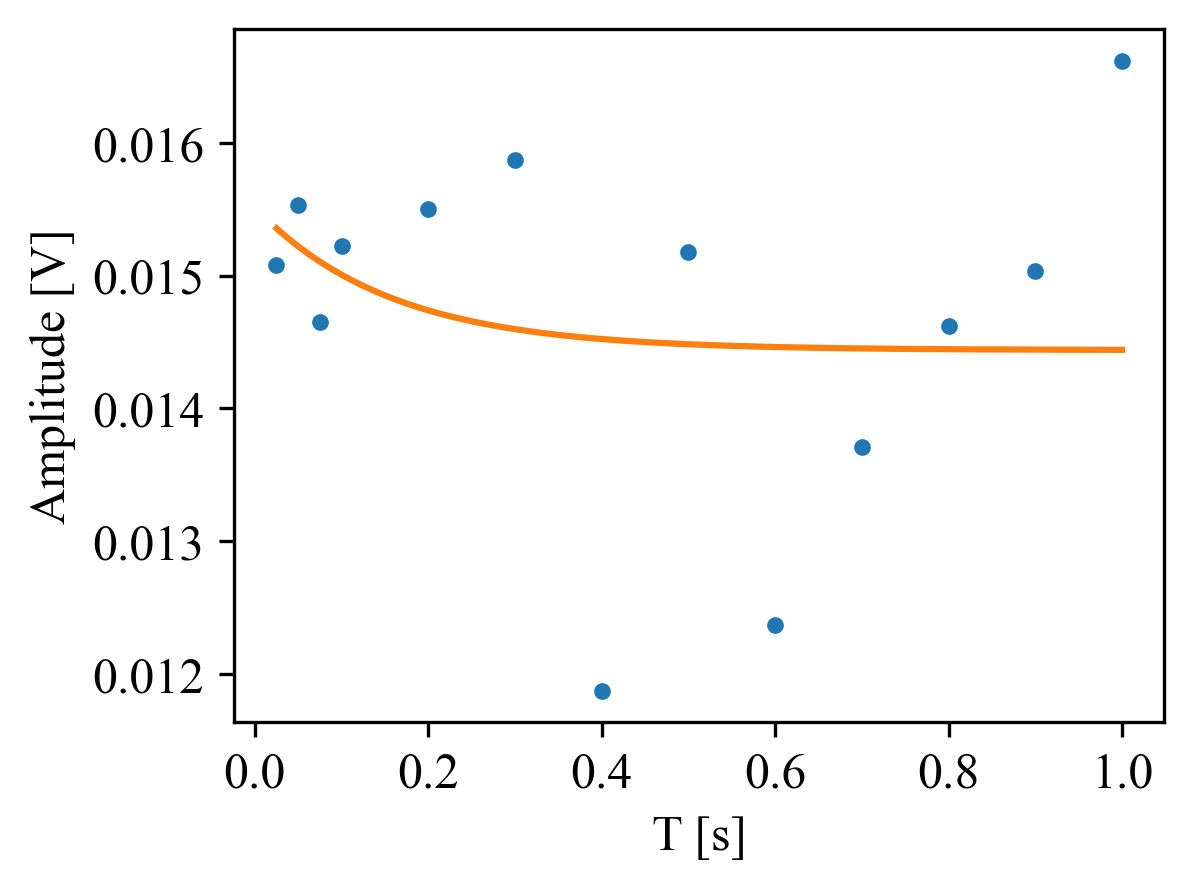

In [18]:
x = period_arr4
y = maxvals4
plt.plot(x, y, '.')
dy = np.ones(len(x)) * 0.00005  # Uncertainty on voltage measurement

# Have an initial guess as to what the values of the parameters are
a_guess = 0.1
b_guess = 100
c_guess = 0.995

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(
    lambda t, a, b, c: 1 - (a * np.exp(-b * t) + c),
    x, y, p0=(a_guess, b_guess, c_guess), sigma=dy
)

# The optimised values of the parameters are
a = popt[0]
b = popt[1]
c = popt[2]

db = pcov[1][1]

T1_iron = 1 / b
dT1_iron = db / b ** 2

x2 = np.linspace(np.amin(x), np.amax(x), 1000)
plt.plot(x2, 1 - (a * np.exp(-b * x2) + c))
# plt.text(0.4, 0.005, f"T1 = {T1_iron:.2f} +/- {dT1_iron:.2f}")
plt.xlabel('T [s]')
plt.ylabel('Amplitude [V]')